# Inizio dei lavori
### I dati sul dataset sono intabellati tra B-8 e P-257

- Python version: 3.12.4
- tensorflow: 2.18.0
- scikeras: 0.13.0
- keras-tuner: 1.4.7

### Librerie installate:
- !pip install tensorflow
- !pip install scikeras
- !pip install keras-tuner

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=20, suppress=True)

my_data = np.genfromtxt('ML-CUP24-TR.csv', delimiter=',')
X = my_data[:, 1:13]
y = my_data[:, 13:16]
print(X.shape, y.shape)

#print(X)
#print(y)

(250, 12) (250, 3)


In [5]:
# Suddividi i dati in train (60%) e temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Suddividi temp in validation (20%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizza i dati
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


In [7]:
# Funzione di attivazione RBF con TensorFlow
def rbf_activation(x, centers, gamma=1.0):
    # Calcola la distanza euclidea tra l'input e i centri
    diff = x[:, np.newaxis, :] - centers
    dist_sq = tf.reduce_sum(tf.square(diff), axis=-1)  # Usa tf.reduce_sum invece di np.sum
    return tf.exp(-gamma * dist_sq)

# Creare il modello
def build_rbf_model(input_dim, output_dim, n_centers=10, gamma=1.0):
    model = models.Sequential()

    # Layer di input: utilizza 'shape' invece di 'input_dim'
    model.add(layers.InputLayer(shape=(input_dim,)))

    # Layer nascosta con attivazione RBF (calcola distanza dal centro)
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)  # Centri randomici
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))

    # Layer di output con una dimensione pari al numero di target (3 in questo caso: x, y, z)
    model.add(layers.Dense(output_dim))

    return model

## Parametri modificabili per cambiare il comportamento del modello:

- <b>Centri</b>: Modificare il numero di centri (n_centers): Se hai un numero troppo basso di centri, il modello potrebbe non essere in grado di catturare abbastanza complessità dei dati. Allo stesso modo, se hai troppi centri, il modello potrebbe overfittare. Prova a sperimentare con valori di n_centers più alti o più bassi.

- <b>Gamma</b>: Modificare il parametro gamma: Gamma controlla la larghezza della funzione RBF. Un valore troppo basso o troppo alto può influire negativamente sul modello. Prova a modificare questo parametro per vedere se migliora la performance.

### Prova del Grid Search di 4 parametri con adam

Trial 90 Complete [00h 00m 05s]
val_loss: 0.45256051421165466

Best val_loss So Far: 0.15239110589027405
Total elapsed time: 00h 04m 19s
Migliori parametri: {'n_centers': 68, 'gamma': 0.17600000000000002, 'learning_rate': 0.04605, 'batch_size': 16, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}
Epoch 1/200
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 1.0290 - mse: 1.0290Epoch 1: Loss=0.731777548789978, Val_Loss=0.5329946875572205
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8512 - mse: 0.8512 - val_loss: 0.5330 - val_mse: 0.5330
Epoch 2/200
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2305 - mse: 0.2305Epoch 2: Loss=0.353060245513916, Val_Loss=0.4133630692958832
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3501 - mse: 0.3501 - val_loss: 0.4134 - val_mse: 0.4134
Epoch 3/200
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1740 - mse: 0.1740Epoch 3: Loss=0.26335862278938293, Val_Loss=0.3360421359539032
10/10

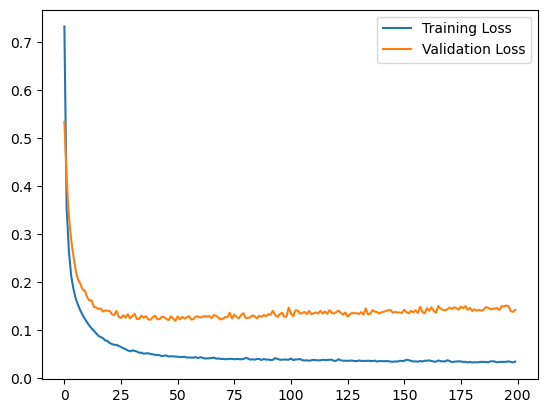

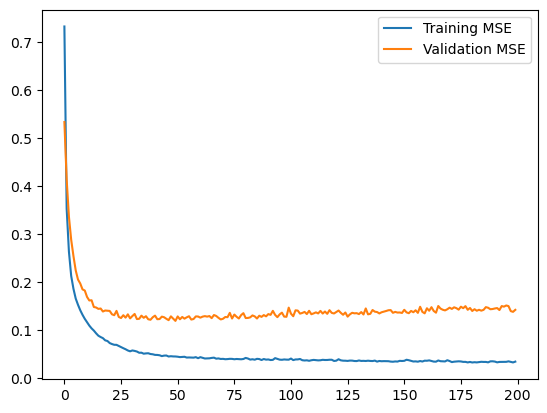

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0535 - mse: 0.0535 
Test Loss: 0.05304403230547905
Test MSE: 0.05304403230547905


In [84]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Funzione per costruire il modello (modificato per Keras Tuner)
def build_rbf_model_tuner(hp):
    input_dim = 12  # Numero di caratteristiche di input
    output_dim = 3  # Numero di target (x, y, z)

    n_centers = hp.Int('n_centers', min_value=15, max_value=70, step=1)
    gamma = hp.Float('gamma', min_value=0.001, max_value=1.0, step=0.025)
    learning_rate = hp.Float('learning_rate', min_value=0.00005, max_value=0.05, step=0.001)
    batch_size = hp.Int('batch_size', min_value=1, max_value=30, step=1)

    # Crea il modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Layer RBF
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))  # Applica l'attivazione RBF

    # Layer di output
    model.add(layers.Dense(output_dim))

    # Ottimizzatore
    optimizer = Adam(learning_rate=learning_rate)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback per visualizzare i progressi di ogni tentativo
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Tuner senza salvataggio dei risultati
tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # Evita di salvare i modelli e i risultati
)

# Esegui la ricerca con log dei progressi
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]  # Stampa i progressi
)

# Ottieni i migliori parametri
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Migliori parametri: {best_hp.values}")

# Costruisci e addestra il modello con i migliori parametri
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

# Plot dei risultati
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

 # Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")


In [75]:
import os
import json

# Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

# Creare una directory per salvare i risultati
results_dir = "results/results007"
os.makedirs(results_dir, exist_ok=True)

# Salvare la Test Loss e i parametri usati
results_data = {
    "Test Loss": test_loss,
    "Test MSE": test_mse,
    "Hyperparameters": best_hp.values  # Parametri migliori trovati
}

with open(os.path.join(results_dir, "results.json"), "w") as f:
    json.dump(results_data, f, indent=4)

# Salvare il grafico di training
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join(results_dir, "training_loss_plot.png"))
plt.close()

plt.figure()
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.title("Training and Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig(os.path.join(results_dir, "training_mse_plot.png"))
plt.close()

print(f"Risultati salvati nella cartella: {results_dir}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0892 - mse: 0.0892
Test Loss: 0.08966238051652908
Test MSE: 0.08966238051652908
Risultati salvati nella cartella: results/results007


### Prova del Grid Search di 5 parametri con SGD

Trial 90 Complete [00h 00m 05s]
val_loss: 1.0309010744094849

Best val_loss So Far: 0.5169310569763184
Total elapsed time: 00h 04m 38s
Migliori parametri: {'n_centers': 54, 'gamma': 0.051000000000000004, 'learning_rate': 0.00395, 'batch_size': 27, 'momentum': 0.9, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0068'}
Epoch 1/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.2821 - mse: 1.2821Epoch 1: Loss=1.327875018119812, Val_Loss=1.1638604402542114
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3094 - mse: 1.3094 - val_loss: 1.1639 - val_mse: 1.1639
Epoch 2/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0405 - mse: 1.0405Epoch 2: Loss=1.0668303966522217, Val_Loss=1.0001405477523804
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0802 - mse: 1.0802 - val_loss: 1.0001 - val_mse: 1.0001
Epoch 3/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8623 - mse: 0.8623Epoch 3: Loss=0.9722771048545837, Val_Loss=0.992044806480407

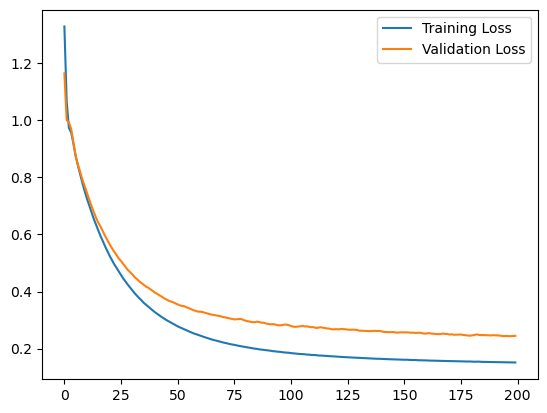

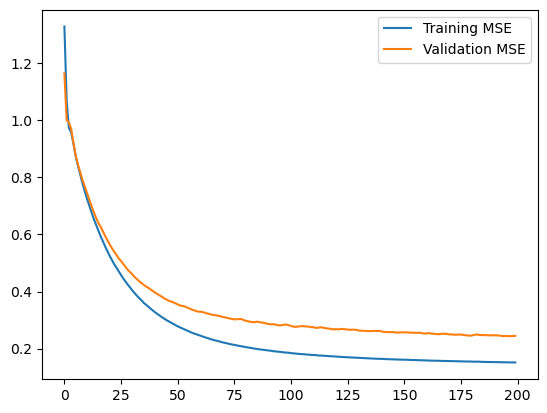

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1444 - mse: 0.1444 
Test Loss: 0.14727142453193665
Test MSE: 0.14727142453193665


In [86]:
from tensorflow.keras.optimizers import SGD

# Funzione per costruire il modello (modificato per Keras Tuner)
def build_rbf_model_tuner(hp):
    input_dim = 12  # Numero di caratteristiche di input
    output_dim = 3  # Numero di target (x, y, z)

    n_centers = hp.Int('n_centers', min_value=15, max_value=70, step=1)
    gamma = hp.Float('gamma', min_value=0.001, max_value=1.0, step=0.025)
    learning_rate = hp.Float('learning_rate', min_value=0.00005, max_value=0.005, step=0.0001)
    batch_size = hp.Int('batch_size', min_value=1, max_value=30, step=1)
    momentum = hp.Float('momentum', min_value=0.0, max_value=0.99, step=0.05)  # Aggiungi momentum come parametro da ottimizzare

    # Crea il modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Layer RBF
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))  # Applica l'attivazione RBF

    # Layer di output
    model.add(layers.Dense(output_dim))

    # Ottimizzatore SGD con momentum
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback per visualizzare i progressi di ogni tentativo
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Tuner senza salvataggio dei risultati
tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # Evita di salvare i modelli e i risultati
)

# Esegui la ricerca con log dei progressi
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]  # Stampa i progressi
)

# Ottieni i migliori parametri
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Migliori parametri: {best_hp.values}")

# Costruisci e addestra il modello con i migliori parametri
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

# Plot dei risultati
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

# Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

In [88]:
import os
import json

# Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

# Creare una directory per salvare i risultati
results_dir = "resultsSGD/results001"
os.makedirs(results_dir, exist_ok=True)

# Salvare la Test Loss e i parametri usati
results_data = {
    "Test Loss": test_loss,
    "Test MSE": test_mse,
    "Hyperparameters": best_hp.values  # Parametri migliori trovati
}

with open(os.path.join(results_dir, "results.json"), "w") as f:
    json.dump(results_data, f, indent=4)

# Salvare il grafico di training
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join(results_dir, "training_loss_plot.png"))
plt.close()

plt.figure()
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.title("Training and Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig(os.path.join(results_dir, "training_mse_plot.png"))
plt.close()

print(f"Risultati salvati nella cartella: {results_dir}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1444 - mse: 0.1444
Test Loss: 0.14727142453193665
Test MSE: 0.14727142453193665
Risultati salvati nella cartella: resultsSGD/results001


### Tensorboard try SGD

Trial 90 Complete [00h 00m 06s]
val_loss: 0.383156955242157

Best val_loss So Far: 0.30452078580856323
Total elapsed time: 00h 07m 33s
Migliori parametri: {'n_centers': 43, 'gamma': 0.07100000000000001, 'learning_rate': 0.0051, 'batch_size': 34, 'momentum': 0.98, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0168 - mse: 1.0168 - val_loss: 1.0237 - val_mse: 1.0237
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0042 - mse: 1.0042 - val_loss: 0.9827 - val_mse: 0.9827
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9528 - mse: 0.9528 - val_loss: 0.9588 - val_mse: 0.9588
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9033 - mse: 0.9033 - val_loss: 0.9433 - val_mse: 0.9433
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8600 - mse: 0.8600 - val_loss: 0.9112 - val_mse: 0.9112
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

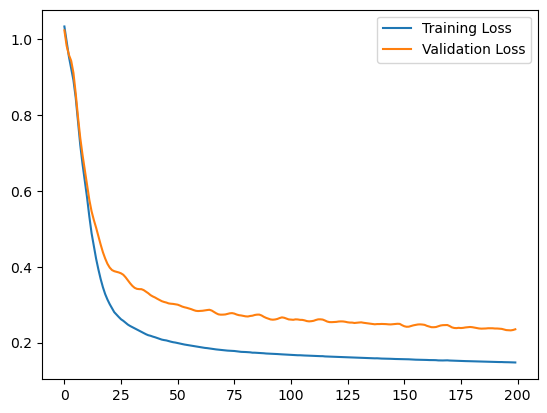

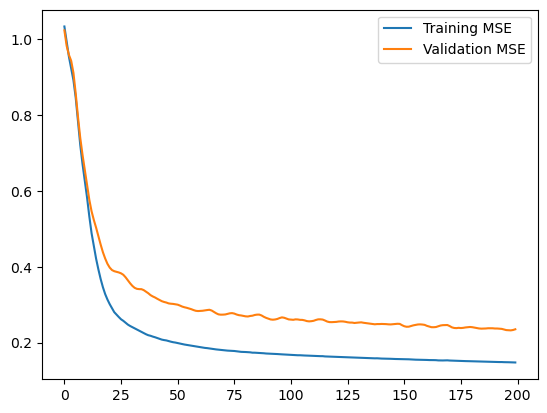

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1471 - mse: 0.1471
Test Loss: 0.15038076043128967
Test MSE: 0.15038076043128967
Run: tensorboard --logdir /tmp/tb_logs


In [134]:
from tensorflow.keras.optimizers import SGD


# Funzione per costruire il modello (modificato per Keras Tuner)
def build_rbf_model_tuner(hp):
    input_dim = 12  # Numero di caratteristiche di input
    output_dim = 3  # Numero di target (x, y, z)

    n_centers = hp.Int('n_centers', min_value=20, max_value=50, step=1)
    gamma = hp.Float('gamma', min_value=0.001, max_value=0.08, step=0.01)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.006, step=0.0005)
    batch_size = hp.Int('batch_size', min_value=20, max_value=40, step=1)
    momentum = hp.Float('momentum', min_value=0.9, max_value=0.99, step=0.005)
    
    # Crea il modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Layer RBF
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))  # Applica l'attivazione RBF

    # Layer di output
    model.add(layers.Dense(output_dim))

    # Ottimizzatore SGD con momentum
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    # Compilazione del modello
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback per visualizzare i progressi di ogni tentativo
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Tuner senza salvataggio dei risultati
tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True  # Evita di salvare i modelli e i risultati
)

# Esegui la ricerca con log dei progressi
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs")]  # Stampa i progressi
)

# Ottieni i migliori parametri
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Migliori parametri: {best_hp.values}")

# Costruisci e addestra il modello con i migliori parametri
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_final_logs")]
)

# Plot dei risultati
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

# Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

print("Run: tensorboard --logdir /tmp/tb_logs")

In [132]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [130]:
!rm -r /tmp/tb_logs
!rm -r /tmp/tb_final_logs

In [136]:
import os
import json

# Valutare il modello sui dati di test
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

# Creare una directory per salvare i risultati
results_dir = "resultsSGD/results002"
os.makedirs(results_dir, exist_ok=True)

# Salvare la Test Loss e i parametri usati
results_data = {
    "Test Loss": test_loss,
    "Test MSE": test_mse,
    "Hyperparameters": best_hp.values  # Parametri migliori trovati
}

with open(os.path.join(results_dir, "results.json"), "w") as f:
    json.dump(results_data, f, indent=4)

# Salvare il grafico di training
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join(results_dir, "training_loss_plot.png"))
plt.close()

plt.figure()
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.title("Training and Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig(os.path.join(results_dir, "training_mse_plot.png"))
plt.close()

print(f"Risultati salvati nella cartella: {results_dir}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1471 - mse: 0.1471
Test Loss: 0.15038076043128967
Test MSE: 0.15038076043128967
Risultati salvati nella cartella: resultsSGD/results002


### Ottimizzazione Adam con learning rate

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0679 - mse: 1.0679 - val_loss: 1.0894 - val_mse: 1.0894
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9722 - mse: 0.9722 - val_loss: 1.0764 - val_mse: 1.0764
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0887 - mse: 1.0887 - val_loss: 1.0632 - val_mse: 1.0632
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9542 - mse: 0.9542 - val_loss: 1.0505 - val_mse: 1.0505
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9962 - mse: 0.9962 - val_loss: 1.0378 - val_mse: 1.0378
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8911 - mse: 0.8911 - val_loss: 1.0254 - val_mse: 1.0254
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9864 - mse: 0.9864 - val_loss: 1.0130 - val_mse: 1.0130
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9322 - mse: 0.9322 - val_loss: 1.0008 - val_mse: 1.0008
Epoch 9/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.967

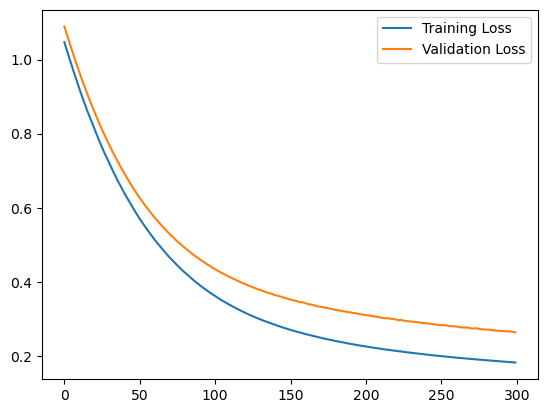

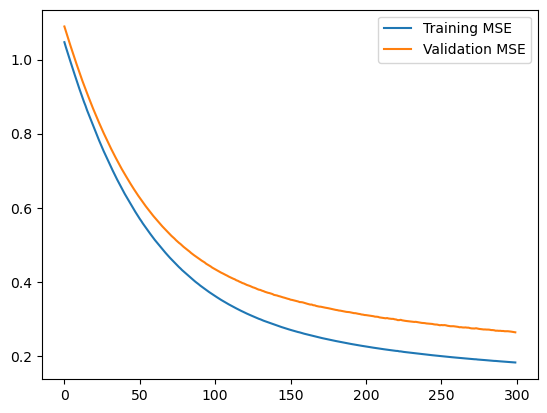

In [9]:
# Definire il modello RBF
input_dim = 12  # Numero di caratteristiche di input
output_dim = 3  # Numero di target (x, y, z)

model = build_rbf_model(input_dim, output_dim, n_centers=35, gamma=0.1)

###################

from tensorflow.keras.optimizers import Adam

# Crea l'ottimizzatore Adam con un learning rate personalizzato
optimizer = Adam(learning_rate=0.001)  # Modifica il valore a seconda delle necessità

# Compila il modello con l'ottimizzatore modificato
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

###############

# Addestrare il modello
history = model.fit(X_train, y_train, epochs=300, batch_size=15, validation_data=(X_val, y_val))

# Plot di perdita e MSE durante l'addestramento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

### Ottimizzazione SGD con learning rate e momentum

Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1424 - mse: 1.1424 - val_loss: 1.0370 - val_mse: 1.0370
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9241 - mse: 0.9241 - val_loss: 1.0005 - val_mse: 1.0005
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0206 - mse: 1.0206 - val_loss: 0.9918 - val_mse: 0.9918
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9603 - mse: 0.9603 - val_loss: 1.0013 - val_mse: 1.0013
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9904 - mse: 0.9904 - val_loss: 0.9400 - val_mse: 0.9400
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8765 - mse: 0.8765 - val_loss: 0.9489 - val_mse: 0.9489
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8871 - mse: 0.8871 - val_loss: 0.9041 - val_mse: 0.9041
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7975 - mse: 0.7975 - val_loss: 0.8615 - val_mse: 0.8615
Epoch 9/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.833

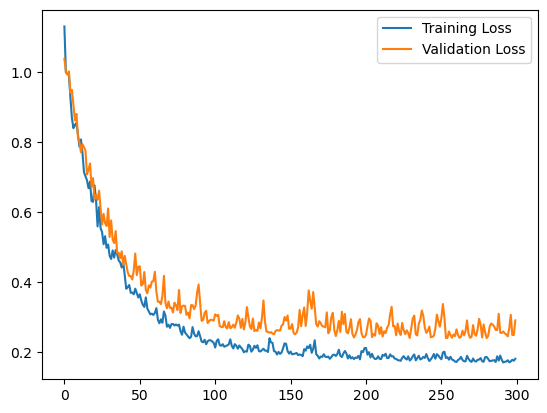

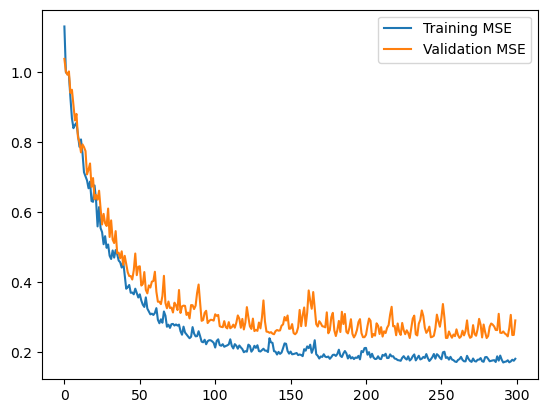

In [15]:
# Definire il modello RBF
input_dim = 12  # Numero di caratteristiche di input
output_dim = 3  # Numero di target (x, y, z)
model = build_rbf_model(input_dim, output_dim, n_centers=35, gamma=0.01)

############

from tensorflow.keras.optimizers import SGD

# Crea l'ottimizzatore SGD con learning rate personalizzato
optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Puoi anche aggiungere il parametro 'momentum'

# Compila il modello
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

#############

# Addestrare il modello
history = model.fit(X_train, y_train, epochs=300, batch_size=10, validation_data=(X_val, y_val))

# Plot di perdita e MSE durante l'addestramento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

### Valutazione modello

In [35]:
# Valutare il modello sui dati di test
test_loss, test_mse = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2061 - mse: 0.2061
Test Loss: 0.2039886862039566
Test MSE: 0.2039886862039566


In [29]:
# Fare previsioni con il modello
y_pred = model.predict(X_test)

# Visualizzare alcune predizioni rispetto ai target reali
print("Predizioni:", y_pred[:5])
print("Target reali:", y_test[:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predizioni: [[ 0.16857463  -1.3636158   -0.19221494 ]
 [-1.5489967   -0.033539027 -0.28831604 ]
 [-0.77353317  -1.34988      0.8789879  ]
 [-1.531677     0.030125499  0.09327796 ]
 [-0.24922329   1.0792842   -0.3782209  ]]
Target reali: [[ 0.27244717367846605  -0.537612753679091    -0.2479354561200379  ]
 [-0.3799851381155657   -0.04186749480216201  -0.44414745362132607 ]
 [-0.7815112003416773   -1.6647466736726686    0.8372008593178114  ]
 [-1.0160175976554373    0.07183957891221614   0.0784562538138544  ]
 [-0.061863766085384984  0.24622992374377972  -0.6653373920183884  ]]
